STAT 479: Machine Learning (Fall 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)   

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-fs2019/

# L14: Dimensionality Reduction 2 -- Feature Extraction

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -p sklearn,mlxtend -v

Sebastian Raschka 2019-11-21 

CPython 3.7.1
IPython 7.9.0

sklearn 0.21.3
mlxtend 0.18.0.dev0


<br>
<br>

## Principal Component Analysis

In [2]:
class PrincipalComponentAnalysis():
    """
    Principal Component Analysis Class

    Parameters
    ----------
    n_components : int (default: None)
        The number of principal components for transformation.
        Keeps the original dimensions of the dataset if `None`.
    solver : str (default: 'eigen')
        Method for performing the matrix decomposition.
        {'eigen', 'svd'}

    Attributes
    ----------
    w_ : array-like, shape=[n_features, n_components]
        Projection matrix
    e_vals_ : array-like, shape=[n_features]
        Eigenvalues in sorted order.
    e_vecs_ : array-like, shape=[n_features]
       Eigenvectors in sorted order.
    loadings_ : array_like, shape=[n_features, n_features]
       The factor loadings of the original variables onto
       the principal components. The columns are the principal
       components, and the rows are the features loadings.
       For instance, the first column contains the loadings onto
       the first principal component. Note that the signs may
       be flipped depending on whether you use the 'eigen' or
       'svd' solver; this does not affect the interpretation
       of the loadings though.

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/feature_extraction/PrincipalComponentAnalysis/

    """
    def __init__(self, n_components=None, solver='eigen'):
        valid_solver = {'eigen', 'svd'}
        if solver not in valid_solver:
            raise AttributeError('Must be in %s. Found %s'
                                 % (valid_solver, solver))
        self.solver = solver

        if n_components is not None and n_components < 1:
            raise AttributeError('n_components must be > 1 or None')
        self.n_components = n_components
        self._is_fitted = False

    def fit(self, X):
        """Learn model from training data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        self : object

        """
        self._is_fitted = False
        self._fit(X=X)
        self._is_fitted = True
        return self

    def _fit(self, X):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        if self.n_components is None or self.n_components > n_features:
            n_components = n_features
        else:
            n_components = self.n_components

        if self.solver == 'eigen':
            cov_mat = self._covariance_matrix(X)
            self.e_vals_, self.e_vecs_ =\
                self._decomposition(cov_mat, n_samples)
        elif self.solver == 'svd':
            self.e_vals_, self.e_vecs_ = self._decomposition(X, n_samples)

        self.w_ = self._projection_matrix(eig_vals=self.e_vals_,
                                          eig_vecs=self.e_vecs_,
                                          n_components=n_components)
        self.loadings_ = self._loadings()
        return self

    def transform(self, X):
        """ Apply the linear transformation on X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        X_projected : np.ndarray, shape = [n_samples, n_components]
            Projected training vectors.

        """
        if not hasattr(self, 'w_'):
            raise AttributeError('Object as not been fitted, yet.')
        return X.dot(self.w_)

    def _covariance_matrix(self, X):
        mean_vec = np.mean(X, axis=0)
        cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0] - 1)
        return cov_mat

    def _decomposition(self, mat, n_samples):
        if self.solver == 'eigen':
            e_vals, e_vecs = np.linalg.eig(mat)
        elif self.solver == 'svd':
            u, s, v = np.linalg.svd(mat.T)
            e_vecs, e_vals = u, s
            e_vals = e_vals ** 2 / n_samples

        sort_idx = np.argsort(e_vals)[::-1]
        e_vals, e_vecs = e_vals[sort_idx], e_vecs[sort_idx]
        return e_vals, e_vecs

    def _loadings(self):
        """Compute factor loadings"""
        return self.e_vecs_ * np.sqrt(self.e_vals_)

    def _projection_matrix(self, eig_vals, eig_vecs, n_components):
        matrix_w = np.vstack([eig_vecs[:, i] for i in range(n_components)]).T
        return matrix_w

In [3]:
from mlxtend.data import iris_data
from mlxtend.preprocessing import standardize
import numpy as np


X, y = iris_data()
X = standardize(X)

pca = PrincipalComponentAnalysis(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

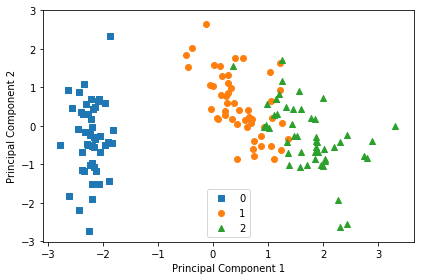

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(6, 4))
for lab, m in zip((0, 1, 2),
                    ('s', 'o', '^')):
    plt.scatter(X_pca[y==lab, 0],
                X_pca[y==lab, 1],
                label=lab,
                marker=m)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

<br>
<br>

### Variance Explained Ratio

In [5]:
import numpy as np

tot = sum(pca.e_vals_)
var_exp = [(i / tot)*100 for i in sorted(pca.e_vals_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

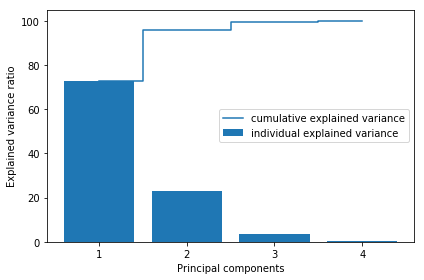

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(range(4), var_exp, align='center',
        label='individual explained variance')
plt.step(range(4), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(4))
ax.set_xticklabels(np.arange(1, X.shape[1] + 1))
plt.legend()
plt.tight_layout()

<br>
<br>

### Factor Loadings

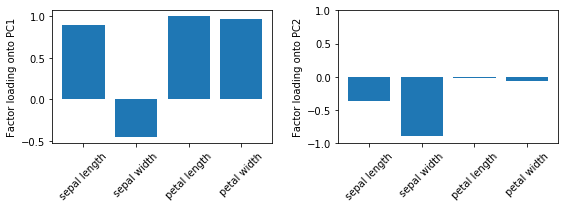

In [7]:
xlabels = ['sepal length', 'sepal width', 'petal length', 'petal width']

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].bar(range(4), pca.loadings_[:, 0], align='center')
ax[1].bar(range(4), pca.loadings_[:, 1], align='center')

ax[0].set_ylabel('Factor loading onto PC1')
ax[1].set_ylabel('Factor loading onto PC2')

ax[0].set_xticks(range(4))
ax[1].set_xticks(range(4))
ax[0].set_xticklabels(xlabels, rotation=45)
ax[1].set_xticklabels(xlabels, rotation=45)
plt.ylim([-1, 1])
plt.tight_layout()

<br>
<br>

### PCA in a Pipeline

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mlxtend.data import wine_data

X, y = wine_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3, stratify=y)

In [9]:
pipe1 = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(n_neighbors=5))

pipe1.fit(X_train, y_train)

print('Orig. training accyracy: %.2f%%' % (pipe1.score(X_train, y_train)*100))
print('Orig. test accyracy: %.2f%%' % (pipe1.score(X_test, y_test)*100))

Orig. training accyracy: 99.19%
Orig. test accyracy: 92.59%


In [10]:
pipe_pca = make_pipeline(StandardScaler(),
                         PCA(n_components=3),
                         KNeighborsClassifier(n_neighbors=5))

pipe_pca.fit(X_train, y_train)


print('Transf. training accyracy: %.2f%%' % (pipe_pca.score(X_train, y_train)*100))
print('Transf. test accyracy: %.2f%%' % (pipe_pca.score(X_test, y_test)*100))

Transf. training accyracy: 96.77%
Transf. test accyracy: 96.30%


Note the reduced overfitting!

<br>
<br>

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [11]:
from mlxtend.data import mnist_data

X, y = mnist_data()

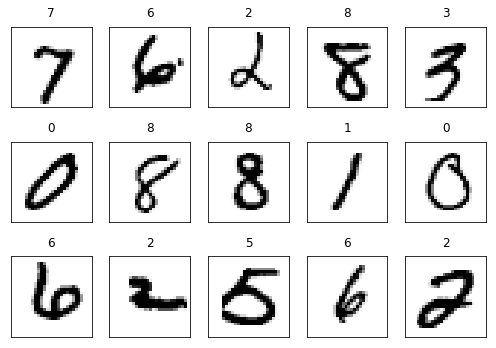

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


nrows, ncols = 3, 5

rng = np.random.RandomState(123)
plt.figure(figsize=(7, 5))

for i in range(ncols * nrows):
    randint = rng.randint(0, 5000)
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X[randint].reshape(28, 28), cmap='Greys')
    plt.xticks([]); plt.yticks([])
    plt.title(y[randint])
    plt.tight_layout()

In [13]:
import matplotlib.patheffects as PathEffects


def plot_projection(x, colors):

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(0, 5000, 500):
        plt.scatter(x[i:i+500, 0], x[i:i+500, 1])

    ax.axis('off')
    ax.axis('tight')
    
    txts = []
    
    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

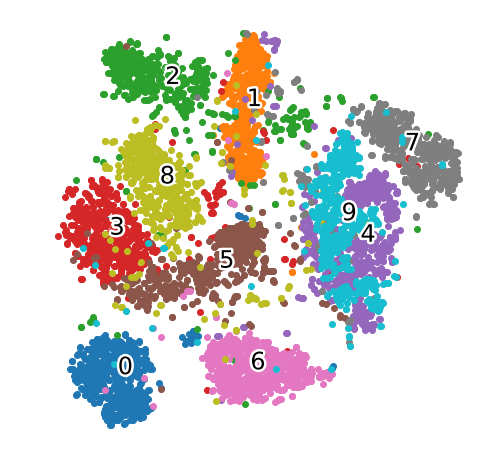

In [14]:
from sklearn.manifold import TSNE


projected = TSNE(n_components=2, perplexity=50.0, learning_rate=200, random_state=123).fit_transform(X)

plot_projection(projected, y)

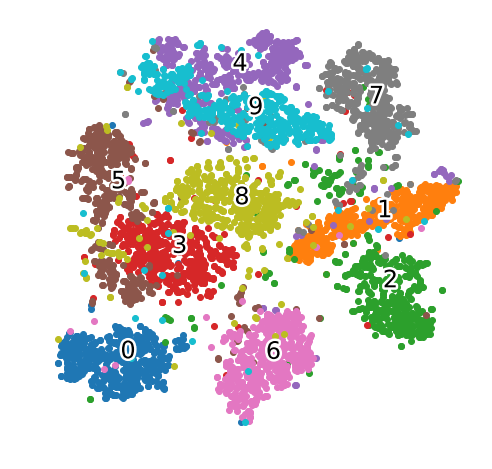

In [15]:
projected = TSNE(n_components=2, perplexity=30.0, learning_rate=200, random_state=123).fit_transform(X)

plot_projection(projected, y)

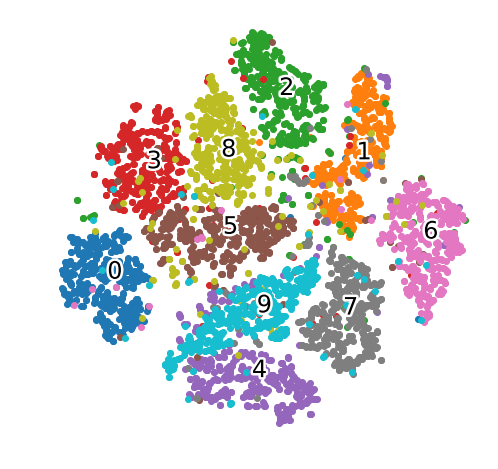

In [16]:
projected = TSNE(n_components=2, perplexity=10.0, learning_rate=200, random_state=123).fit_transform(X)

plot_projection(projected, y)

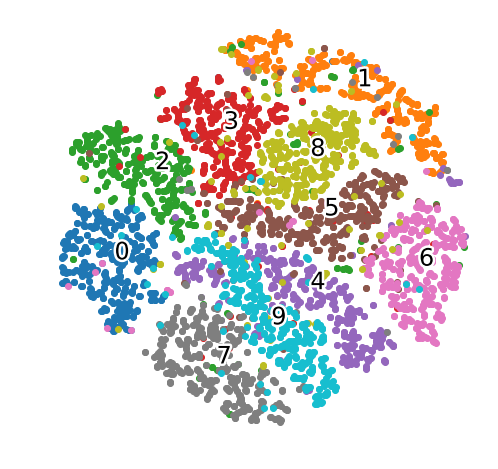

In [17]:
projected = TSNE(n_components=2, perplexity=5.0, learning_rate=200, random_state=123).fit_transform(X)

plot_projection(projected, y)